In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import torch.nn as nn
import torch.optim as optim
import cv2
import tqdm

# <strong> Self-supervised feature extraction for ball detection in nao robots

## <strong >What is self-supervised learning?

Self-supervised learning is a machine learning paradigm where models learn from unlabeled data by solving pretext tasks that generate supervisory signals from the data itself. In this project, we aim to leverage self-supervised learning to enhance the performance of the ball perceptron model used by the Sapienza SPQR team in the RoboCup SPL, specifically for Nao robots. Our goal is to improve the model's ability to detect and analyze balls, a critical task for robotic soccer. To achieve this, we explore a range of carefully chosen pretext tasks, including triplet loss for feature embedding, colorization to reconstruct color information, and edge detection to focus on structural details of the ball. These tasks are designed to enable the model to learn robust and high-level features that will ultimately improve its accuracy and reliability in real-world scenarios.

## <strong> Create a general dataset to be used

In [2]:
#Initial paths config
annotations_path = 'spqr_dataset/raw/merged.csv'
images_path = '/home/pavka/SPQRdetector/SPQR-detector/merged'

DEBUG = False
TESTING = False

In [3]:
from src.BallPatchesDataset import BallPatchesDataset

transform = transforms.Compose([
    transforms.ToTensor(),          # Convert image to PyTorch tensor
])

dataset = BallPatchesDataset(annotations_path, images_path, transform=transform) # Create a dataset for BallPatches


In [ ]:
# check 1 go through the dataset to check if it crashes
import tqdm
if TESTING:
    for i in tqdm.tqdm(range(len(dataset))):
        dataset.__getitem__(i)


How does the dataset look like

In [4]:
for k in dataset[0]:
    print(k)

original_img
patch
bbx
contains_ball


### <strong> Test dataset

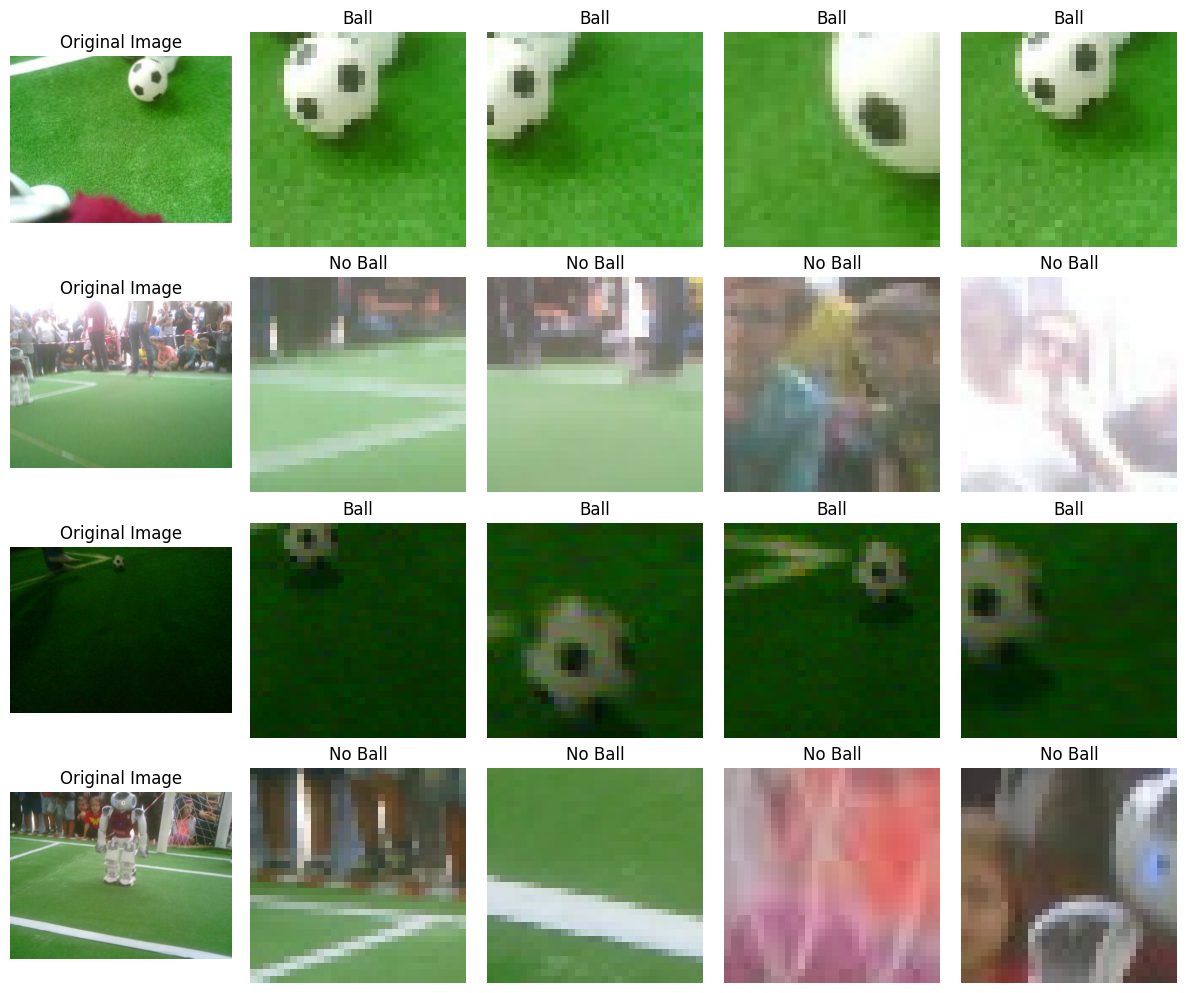

In [14]:
def plot_patches_with_original(dataset, num_rows=4, num_patches_per_row=4):
    """
    Plots the original images and their patches in a grid.

    :param dataset: The BallPatchesDataset instance.
    :param num_rows: Number of rows to display (each row corresponds to an original image).
    :param num_patches_per_row: Number of patches to display per row.
    """
    num_cols = num_patches_per_row + 1  # Including the original image
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10))
    axes = axes.reshape(num_rows, num_cols)

    for row in range(num_rows):
        # Randomly sample an original image and patches
        idx = random.randint(0, len(dataset) - 1)
        sample = dataset[idx]
        original_img = sample["original_img"].permute(1, 2, 0).numpy() * 255  # Convert CHW to HWC
        original_img = original_img.astype("uint8")
        axes[row, 0].imshow(original_img)
        axes[row, 0].axis("off")
        axes[row, 0].set_title("Original Image")
        
        # Plot the patches
        for col in range(1, num_cols):
            patch_sample = dataset[idx]
            patch = patch_sample["patch"].permute(1, 2, 0).numpy() * 255
            contains_ball = patch_sample["contains_ball"]

            axes[row, col].imshow(patch.astype("uint8"))
            axes[row, col].axis("off")
            axes[row, col].set_title("Ball" if contains_ball else "No Ball")
    
    plt.tight_layout()
    plt.show()


plot_patches_with_original(dataset, num_rows=4, num_patches_per_row=4)


We filtered out all the trivial patches using canny edge detection, here's a visual example.

In [200]:
from utils.functions import *
image_path = 'merged/upper_103742_jpg.rf.93f52e15897762e1f69462ced896abdc.jpg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

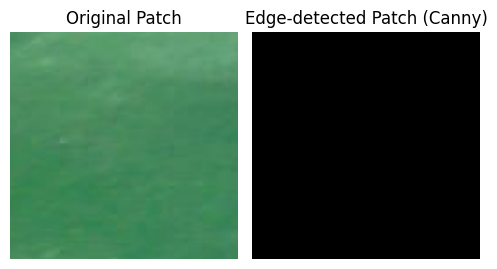

In [258]:
patch = get_random_patch(image, patch_size=128)
display_patch_and_edges(patch)

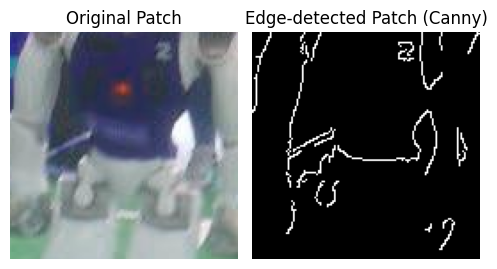

In [251]:
patch = get_random_patch(image, patch_size=128)
display_patch_and_edges(patch)

## <strong> Different pretext task models

### <strong> Triplet loss

Triplet Loss is a loss function commonly used in machine learning, particularly in tasks like metric learning and face recognition. It is designed to learn embeddings that map similar items closer together and dissimilar items farther apart in a high-dimensional space.

The triplet loss is based on three inputs:

    Anchor: The reference sample (e.g., an image of a person).
    Positive: A sample of the same class as the anchor (e.g., another image of the same person).
    Negative: A sample of a different class (e.g., an image of a different person).

#### Define loss function

In [34]:
distance_function = lambda x, y: torch.sqrt(torch.sum((x - y) ** 2, dim=-1))


def train_triplet_loss(model, dataloader, optimizer, margin=1.0, device = 'cpu'):
    model.to(device)
    model.train()
    criterion = nn.TripletMarginWithDistanceLoss(margin=margin,  distance_function = distance_function)
    running_loss = 0.0

    for batch in dataloader:
        anchor_patches = batch['anchor'].to(device)
        positive_patches = batch['positive'].to(device)
        negative_patches = batch['negative'].to(device)

        optimizer.zero_grad()

        anchor_embeddings = model(anchor_patches)
        positive_embeddings = model(positive_patches)
        negative_embeddings = model(negative_patches)

        loss = criterion(anchor_embeddings, positive_embeddings, negative_embeddings)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(dataloader)


def eval_triplet_loss(model, dataloader, margin=1.0, device = 'cpu'):
    model.to(device)
    model.eval()
    criterion = nn.TripletMarginWithDistanceLoss(margin=margin,  distance_function = distance_function)
    running_loss = 0.0
    
    with torch.no_grad():
        for batch in dataloader:
            
            anchor_patches = batch['anchor'].to(device)
            positive_patches = batch['positive'].to(device)
            negative_patches = batch['negative'].to(device)

            anchor_embeddings = model(anchor_patches)
            positive_embeddings = model(positive_patches)
            negative_embeddings = model(negative_patches)

            loss = criterion(anchor_embeddings, positive_embeddings, negative_embeddings)
            running_loss += loss.item()

    return running_loss / len(dataloader)

#### Create dataloader and model

The triplet hard mining strategy was implemented by first training a standard triplet model without triplet mining, and then utilizing the trained model to perform triplet mining for further refinement.

In [ ]:
from src.TripletModel import TripletBallPerceptor
state_dict = torch.load('weights/tripletHard.pt', map_location='cuda')
model = TripletBallPerceptor()
model.load_state_dict(state_dict)

In [19]:
from src.TripletBallPatchesDataset import TripletBallPatchesDataset
from torch.utils.data import random_split, DataLoader

triplet_dataset = TripletBallPatchesDataset(dataset,model,k=20, batch_size=256)

100%|██████████| 1941/1941 [5:51:07<00:00, 10.85s/it]  


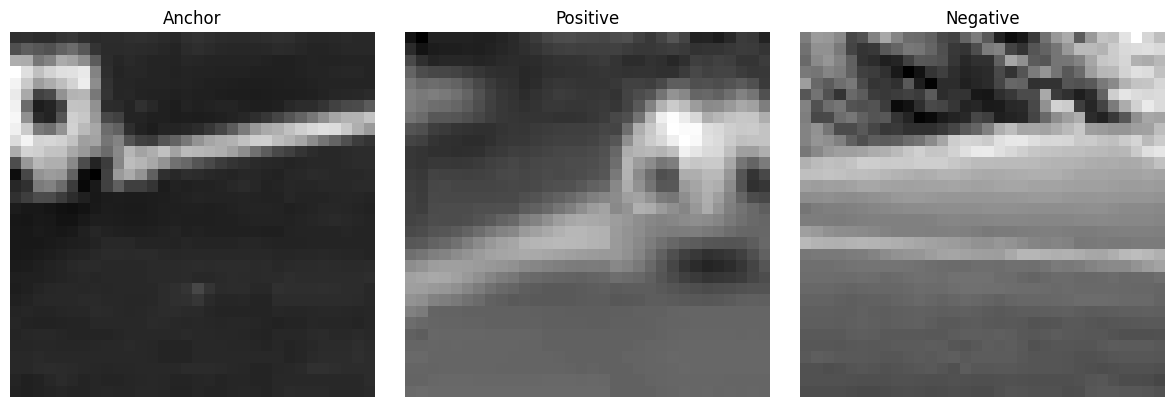

In [28]:
triplet_dataset.show(60)

In [52]:
# Define the split proportions
train_ratio = 0.8  # 80% for training, 20% for validation

# Calculate sizes for train and validation datasets
dataset_size = len(triplet_dataset)
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

batch_size = 5012

# Perform the split
train_dataset, val_dataset = random_split(triplet_dataset, [train_size, val_size])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Train dataset size: 31056
Validation dataset size: 7764


In [ ]:
from src.TripletModel import TripletBallPerceptor

# Hyperparameters
EPOCHS = 200
LEARNING_RATE = 1e-5
MARGIN = 1.0


# Initialize Model, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TripletBallPerceptor()

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

best_val_loss = 1.8144 # empirical low
best_val_loss =float('inf')

# Training Loop
for epoch in range(EPOCHS):
    train_loss = train_triplet_loss(model, train_loader, optimizer, margin=MARGIN, device='cuda')
    val_loss = eval_triplet_loss(model, val_loader,margin=MARGIN,device=device)
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), 'tripletHarder2.pt')
        best_val_loss = val_loss
        print("Saved Weights")

    print(f"Epoch {epoch + 1}/{EPOCHS} | Train_loss: {train_loss:.4f} | Validation_loss: {val_loss:.4f}")


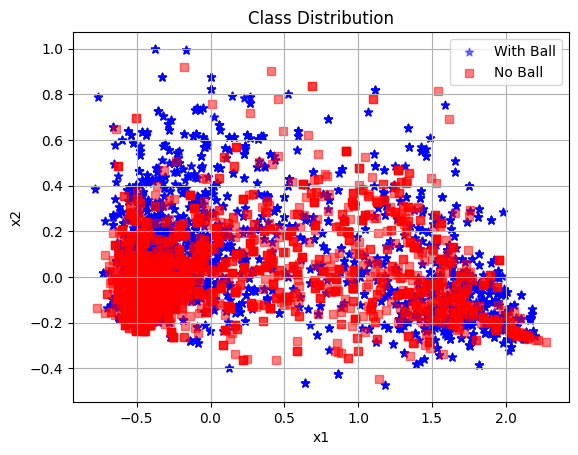

In [ ]:
all_patch = total_patches(triplet_dataset)
encodings = create_encoding_df(model, all_patch)
encodings_pca = apply_pca_to_dataframe(encodings)
plot_classes(encodings_pca)

## <strong> Colorization

- The **colorization problem** in image processing refers to the task of adding plausible colors to grayscale images. 
The challenge lies in determining and assigning accurate and contextually appropriate colors to different parts of the image, often relying on both local features and global scene understanding.

> The *ColorizationDataset* is a custom PyTorch dataset designed to prepare data for image colorization tasks.

We have made few steps in order to transform our dataset to be suitable for our problem:

- The dataset is initialized with a source dataset (*BallPatchDataset*), which is expected to contain image patches.

- **Original Image Patch**: The method accesses the patch field of the dataset at the specified index.

- **Grayscale Conversion**: The grayscale version is computed by averaging the color channels (mean across the first dimension)

- The method returns a dictionary with:

    - **gray**: The computed grayscale image.

    - **original**: The original color image patch.

In [4]:
from src.ColorizationDataset import ColorizationDataset
colorization_dataset = ColorizationDataset(dataset)

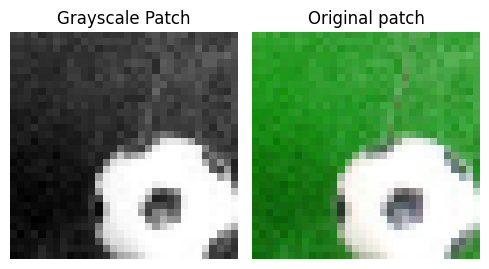

In [29]:
colorization_dataset.show(10)

#### <strong> **Create Dataloader**

> We create the *train_loader* and *val_loader* to train and evaluate the dataset

In [12]:
from torch.utils.data import random_split, DataLoader

# Define the ratio for splitting the dataset into training and validation sets
train_ratio = 0.8  # 80% of the data will be used for training, 20% for validation

# Calculate the sizes of the train and validation datasets based on the ratio
dataset_size = len(colorization_dataset)  # Get the total number of samples in the dataset
train_size = int(train_ratio * dataset_size)  # Size of the training dataset
val_size = dataset_size - train_size  # Remaining data will be for the validation dataset

# Define the batch size for loading data
batch_size = 128

# Split the dataset into training and validation datasets using random_split
train_dataset, val_dataset = random_split(colorization_dataset, [train_size, val_size])

# Create DataLoader for the training dataset with shuffling enabled for randomness in training
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

# Create DataLoader for the validation dataset without shuffling (validation data should remain fixed)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

# Print the sizes of the train and validation datasets
print(f"Train dataset size: {len(train_dataset)}")  # Display the number of samples in the training dataset
print(f"Validation dataset size: {len(val_dataset)}")  # Display the number of samples in the validation dataset


Train dataset size: 4887
Validation dataset size: 1222


#### **Training**

> We have trained our model using an *Adam Optimizer* and *MSELoss*

In [9]:
from src.ColorizationModel import ColorizationModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ColorizationModel()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()   # MSE VERSION
# criterion = torch.nn.L1Loss()   # MAE VERSION
num_epochs = 20

In [ ]:
best_val_loss = float('inf')  # Initialize the best validation loss to infinity to ensure the first validation loss will be saved

# Training loop over the number of epochs
for epoch in range(num_epochs):

    model.train()
    train_loss = 0.0 
    for batch in tqdm.tqdm(train_loader):  # Iterate through the training data loader
        grayscale_patch = batch['gray'].to(device)  
        color_patch = batch['original'].to(device)  
        
        # Forward pass: Pass the grayscale input through the model to get the predicted colorized image
        optimizer.zero_grad()  
        predicted_image = model(grayscale_patch)  # Perform forward pass and get predicted output

        # Compute the loss between the predicted image and the ground truth (colorized image)
        loss = criterion(predicted_image, color_patch)
        loss.backward() 
        optimizer.step()  

        train_loss += loss.item() 

    model.eval()
    val_loss = 0.0  
    with torch.no_grad(): 
        for batch in val_loader:  
            grayscale_patch = batch['gray'].to(device)  
            color_patch = batch['original'].to(device)  

            predicted_image = model(grayscale_patch)  

            # Compute the loss for the validation batch
            loss = criterion(predicted_image, color_patch)
            val_loss += loss.item()  

    # If the current validation loss is lower than the best validation loss, save the model's weights
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), 'weights/colorizationMSETest.pt')  # Save the model's weights to a file (change the name accordingly)
        best_val_loss = val_loss  # Update the best validation loss
        print("Saved Weights")  # Indicate that the model weights were saved due to a lower validation loss

    print(f'Epoch [{epoch+1}/{num_epochs}], '  # Display current epoch number
            f'Train Loss: {train_loss/len(train_loader):.4f}, '  # Average training loss for this epoch
            f'Val Loss: {val_loss/len(val_loader):.4f}')  # Average validation loss for this epoch


#### **Evaluation**


- The **display_colorization_prediction** function visualizes the performance of a colorization model. It selects a random image from the dataset, retrieves its grayscale input and ground truth color image, and processes the grayscale image through the model to generate a colorized output.

- The grayscale, model-generated output, and ground truth images are converted to NumPy arrays for visualization. These images are displayed side by side: the grayscale input in grayscale, the model’s colorized output in color, and the ground truth color image. This comparison highlights the model's accuracy in colorizing the grayscale input.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.10789175..1.0063897].


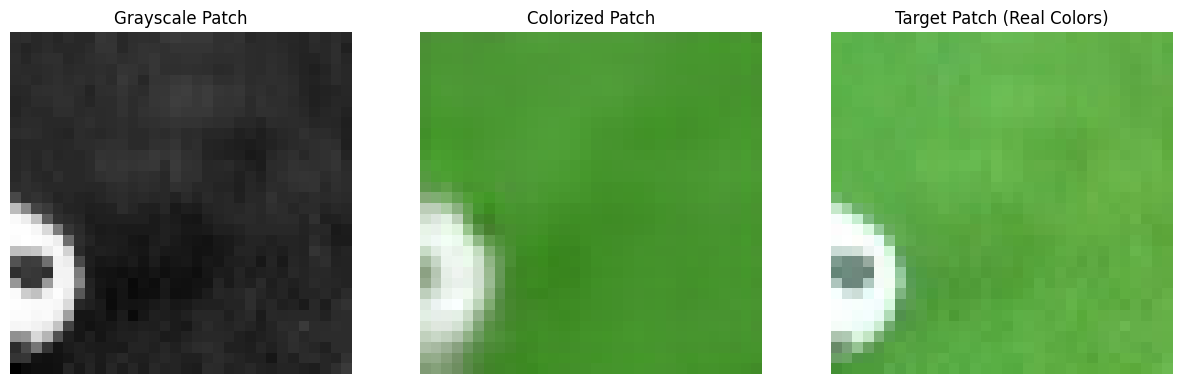

In [ ]:
from utils.functions import *
model = ColorizationModel()
# Load the weights trained
model.load_state_dict(torch.load('weights/model_weights_MSE.pt', weights_only=True))  # Load the saved weights.
model.eval()  # Set the model to evaluation mode.

# We use the function to display a random pic in the dataset, evaluating it with the model saved
display_colorization_prediction(model, colorization_dataset)

## <strong> Edge detection

Another pretext task we are evaluating involves predicting the edges of an image, with the ground truth being the edge map generated using the Sobel operator on the corresponding patch.

In [5]:
from src.EdgeDataset import Edgedataset
edgedataset = Edgedataset(dataset)

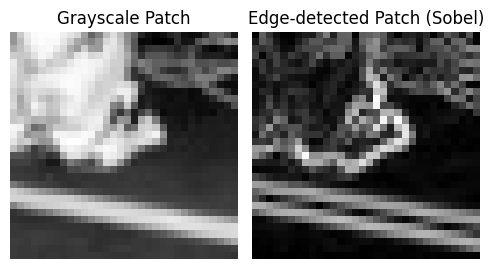

In [ ]:
edgedataset.show(4) #example on how the dataset looks like

In [126]:
from torch.utils.data import random_split, DataLoader
# Define the split proportions
train_ratio = 0.8  # 80% for training, 20% for validation

# Calculate sizes for train and validation datasets
dataset_size = len(edgedataset)
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

batch_size = 128

# Perform the split
train_dataset, val_dataset = random_split(edgedataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=8)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 4887
Validation dataset size: 1222


In [143]:
from src.EdgeModel import EdgeDetection

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EdgeDetection().to(device)
criterion = torch.nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 10
# Set the initial best validation loss
best_val = 0.0055

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in tqdm.tqdm(train_loader):
        # Load data
        grayscale_patches = batch['gray'].to(device)  # Grayscale patches
        target_edges = batch['edge'].to(device)  # Ground truth (edge map)

        # Forward pass
        outputs = model(grayscale_patches)
        optimizer.zero_grad()

        # Compute the loss
        loss = criterion(outputs, target_edges)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Switch model to evaluation mode
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch in val_loader:
            # Load validation data
            grayscale_patches = batch['gray'].to(device)  # Grayscale patches
            target_edges = batch['edge'].to(device)  # Ground truth (edge map)
            # Forward pass for validation
            output = model(grayscale_patches)
            val_loss += criterion(output, target_edges)
        val_loss /= len(val_loader)
        
        # Save the model weights if validation loss improves
        if val_loss < best_val:
            torch.save(model.state_dict(), 'edgeTest.pt')
            best_val = val_loss
            print("Saved Weights")

    # Log training and validation results
    print(f'Epoch {epoch+1} ---- training loss: {train_loss:.4f} ---- validation loss: {val_loss:.4f}')


100%|██████████| 39/39 [00:14<00:00,  2.65it/s]


Saved Weights
Epoch 1 ---- training loss: 0.0134 ---- validation loss: 0.0110


100%|██████████| 39/39 [00:14<00:00,  2.66it/s]


Saved Weights
Epoch 2 ---- training loss: 0.0080 ---- validation loss: 0.0080


100%|██████████| 39/39 [00:14<00:00,  2.60it/s]


Saved Weights
Epoch 3 ---- training loss: 0.0069 ---- validation loss: 0.0068


100%|██████████| 39/39 [00:14<00:00,  2.67it/s]


Saved Weights
Epoch 4 ---- training loss: 0.0065 ---- validation loss: 0.0063


100%|██████████| 39/39 [00:15<00:00,  2.55it/s]


Saved Weights
Epoch 5 ---- training loss: 0.0063 ---- validation loss: 0.0061


100%|██████████| 39/39 [00:15<00:00,  2.52it/s]


Epoch 6 ---- training loss: 0.0060 ---- validation loss: 0.0061


100%|██████████| 39/39 [00:15<00:00,  2.55it/s]


Saved Weights
Epoch 7 ---- training loss: 0.0060 ---- validation loss: 0.0056


100%|██████████| 39/39 [00:14<00:00,  2.64it/s]


Epoch 8 ---- training loss: 0.0058 ---- validation loss: 0.0056


100%|██████████| 39/39 [00:15<00:00,  2.55it/s]


Epoch 9 ---- training loss: 0.0057 ---- validation loss: 0.0057


100%|██████████| 39/39 [00:14<00:00,  2.68it/s]


Saved Weights
Epoch 10 ---- training loss: 0.0056 ---- validation loss: 0.0055


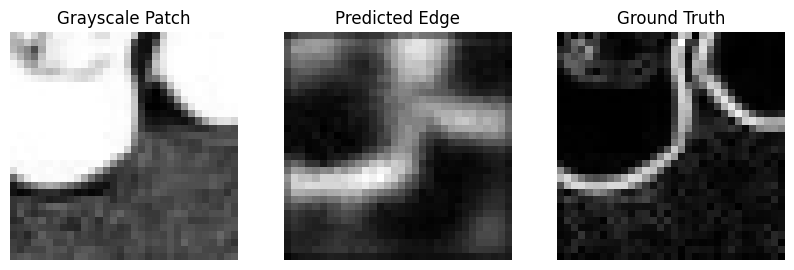

In [ ]:
state_dict = torch.load('weights/edge.pt', map_location='cuda')
model = EdgeDetection()
model.load_state_dict(state_dict)
sample = edgedataset[10]
display_edge_prediction(model, sample, device)